#### Import Libraries

In [1]:
import sys
sys.path.append('/Users/w5b0h0/Desktop/gradient normalization/gradient normalization')

import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from algorithms import QSGD, EF21, FedAvg
# from utils.util import create_fresh_models
from utils import Client, Server, create_fresh_models, plot_accuracy_comparison, plot_loss_comparison, plot_min_function_values
from model import LogisticRegressionBinary, MLP, ResNet, resnet18
from data import split_doubly_stochastic_direct, get_mnist_dataset, get_cifar10_dataset, get_mnist_binary_dataset
from torchvision import datasets, transforms

import random


Input shape: torch.Size([32, 3, 32, 32])
Output shape: torch.Size([32, 10])


#### Obtain Heterogeneous Data

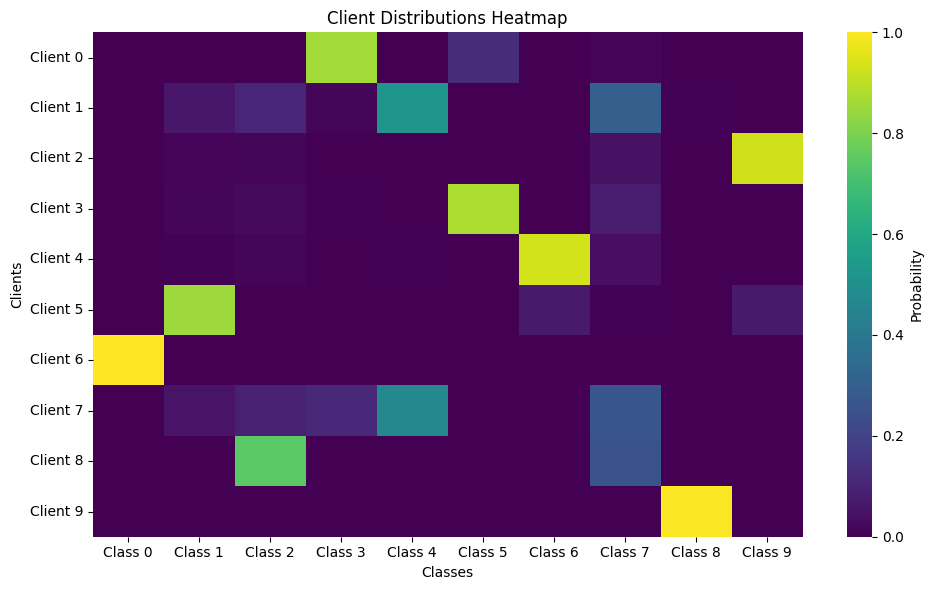

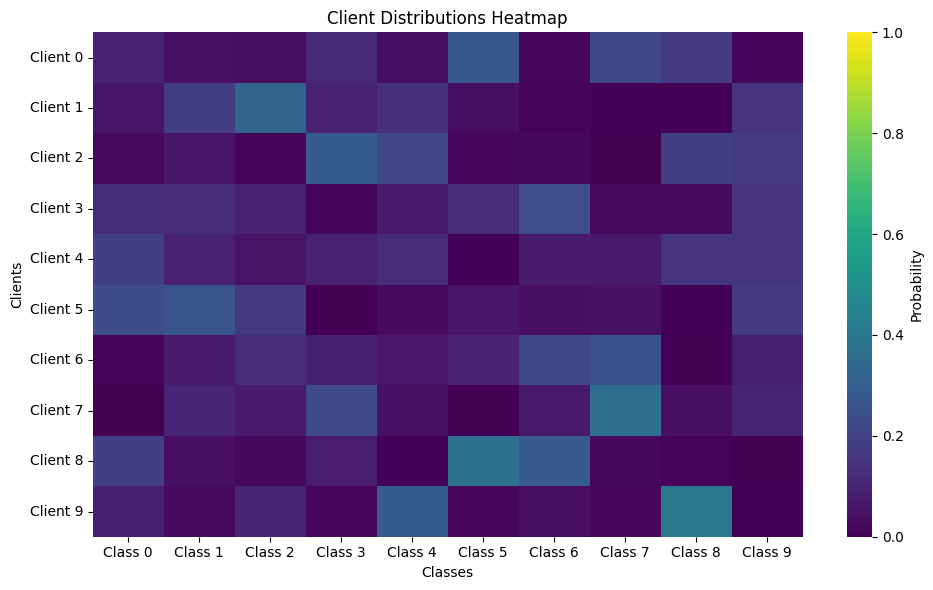

array([[9.53201875e-02, 3.90795060e-02, 3.79386023e-02, 1.09906279e-01,
        3.25533003e-02, 2.70928979e-01, 1.56566519e-02, 2.14898944e-01,
        1.69198230e-01, 1.45193143e-02],
       [5.37207872e-02, 1.78412810e-01, 3.25046986e-01, 9.52427015e-02,
        1.38319686e-01, 3.63511518e-02, 9.52923018e-03, 5.84439095e-03,
        7.35306554e-03, 1.50179207e-01],
       [2.70395782e-02, 5.85472696e-02, 1.42052546e-02, 2.86115617e-01,
        2.14468420e-01, 1.67186446e-02, 2.03095842e-02, 1.55129342e-03,
        1.87251359e-01, 1.73793033e-01],
       [1.31437883e-01, 1.26665100e-01, 9.34102088e-02, 1.39640812e-02,
        7.00683296e-02, 1.26514897e-01, 2.37232119e-01, 2.47685183e-02,
        2.71415208e-02, 1.48797289e-01],
       [1.87423438e-01, 9.23883691e-02, 5.03523350e-02, 9.20864865e-02,
        1.21422127e-01, 7.24797696e-03, 7.22118467e-02, 6.68325424e-02,
        1.56114250e-01, 1.53920680e-01],
       [2.29019463e-01, 2.65078694e-01, 1.63227126e-01, 1.35629771e-05,
   

In [74]:
seed=26
random.seed(seed)
torch.manual_seed(seed)

train_dataset, test_dataset = get_mnist_dataset()

num_clients = 10
num_classes = 10
alpha1 = 0.1
alpha2 = 10


dataset_list1, client_distribution1 = split_doubly_stochastic_direct(train_dataset,alpha1,num_clients,num_classes)
dataset_list2, client_distribution2 = split_doubly_stochastic_direct(train_dataset,alpha2,num_clients,num_classes)

batch_size = 4
inner_lr = 0.001

client_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
server_device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

from utils import visualize_client_distributions

visualize_client_distributions(client_distribution1)

visualize_client_distributions(client_distribution2)

#### Experimental Algorithm and Parameter Settings

In [141]:
theta = 0.9
iteration = 61
criterion = torch.nn.CrossEntropyLoss()
inner_iter = 1
inner_lr = 0.01
gamma = 0.3
compressor_type = "top_k"
K = 0.3
R = 2
algorithms_to_test = ["QSGD-GN-M","EF21-SGDM"]

loss_results = {}
acc_results = {}
record_interval ={}

for algo_name in algorithms_to_test:

    for r in range(1,R+1):
        if r>1 and algo_name in ["EF21-SGDM","EF21-SGD"]:
            break

        if algo_name in ["QSGD","QSGD-GN","QSGD-M","QSGD-GN-M"]:
            clients, server = create_fresh_models("MLP", dataset_list1, train_dataloader, test_dataloader, 
                                            r*batch_size, num_classes, inner_lr, client_device, server_device,algo_name,theta)
        else:
            clients, server = create_fresh_models("MLP", dataset_list1, train_dataloader, test_dataloader, 
                                            batch_size, num_classes, inner_lr, client_device, server_device,algo_name,theta)
        

        # print(clients[1].dataloader)
        if algo_name in ["EF21-SGD", "EF21-SGDM"]:
            algorithm = EF21(clients, server, theta, algo_name, compressor_type, compressor_param=K, compress_round=1)
            loss, acc = algorithm.ef21(iteration, criterion, gamma, inner_iter, record_interval=2, lr_decay=True)
        elif algo_name in ["QSGD","QSGD-GN","QSGD-M","QSGD-GN-M"]:
            algorithm = QSGD(clients, server, theta, algo_name, compressor_type, compressor_param=K, compress_round=r)
            loss, acc, grad_norm = algorithm.qsgd(iteration, criterion, gamma, inner_iter, lr_decay=True, record_interval=R-r+1)


        if algo_name in ["QSGD","QSGD-GN","QSGD-M","QSGD-GN-M"]:
            loss_results[f"{algo_name} u={r}"] = loss
            acc_results[f"{algo_name} u={r}"] = acc
            record_interval[f"{algo_name} u={r}"] = r
        else:
            loss_results[algo_name] = loss
            acc_results[algo_name] = acc
            record_interval[algo_name] = 1

Norm = 0.504137396812439
QSGD-GN-M Round 0: Loss = 2.1634, Accuracy = 22.30%
Norm = 0.7311735153198242
QSGD-GN-M Round 2: Loss = 1.8469, Accuracy = 36.95%
Norm = 0.9044772386550903
QSGD-GN-M Round 4: Loss = 1.5775, Accuracy = 50.93%
Norm = 0.9460014700889587
QSGD-GN-M Round 6: Loss = 1.4037, Accuracy = 57.69%
Norm = 0.9872300028800964
QSGD-GN-M Round 8: Loss = 1.2438, Accuracy = 63.88%
Norm = 0.9928564429283142
QSGD-GN-M Round 10: Loss = 1.1115, Accuracy = 67.73%
Norm = 1.0345051288604736
QSGD-GN-M Round 12: Loss = 0.9964, Accuracy = 70.90%
Norm = 1.041510820388794
QSGD-GN-M Round 14: Loss = 0.9177, Accuracy = 71.89%
Norm = 1.0013117790222168
QSGD-GN-M Round 16: Loss = 0.8649, Accuracy = 73.17%
Norm = 0.9622030854225159
QSGD-GN-M Round 18: Loss = 0.8433, Accuracy = 73.48%
Norm = 0.919231653213501
QSGD-GN-M Round 20: Loss = 0.7754, Accuracy = 76.74%
Norm = 0.9422704577445984
QSGD-GN-M Round 22: Loss = 0.6945, Accuracy = 79.72%
Norm = 0.9070032835006714
QSGD-GN-M Round 24: Loss = 0.6543,

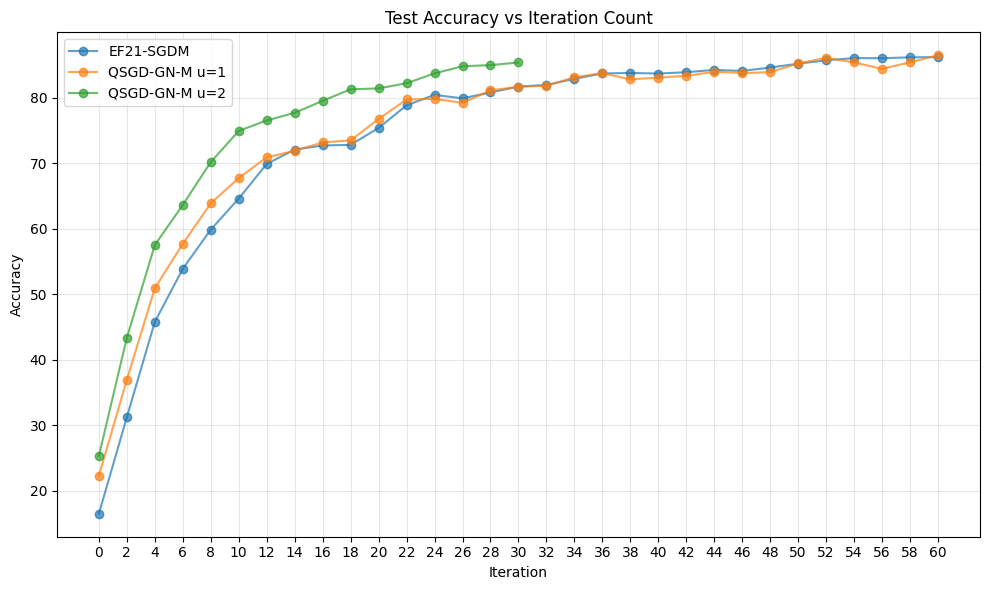

In [165]:
import matplotlib.pyplot as plt
import numpy as np
figsize=(10, 6)
title='Test Accuracy vs Iteration Count'
acc_results

plt.figure(figsize=figsize)

x = np.arange(0,len(acc_results["EF21-SGDM"])*2,2)
    
plt.plot(x, acc_results["EF21-SGDM"], '-o', label="EF21-SGDM", alpha=0.7)
plt.plot(x, acc_results["QSGD-GN-M u=1"], '-o', label="QSGD-GN-M u=1", alpha=0.7)
plt.plot(np.arange(0,len(acc_results["EF21-SGDM"]),2), acc_results["QSGD-GN-M u=2"][::2], '-o', label="QSGD-GN-M u=2", alpha=0.7)
plt.title(title)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.xticks(x)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

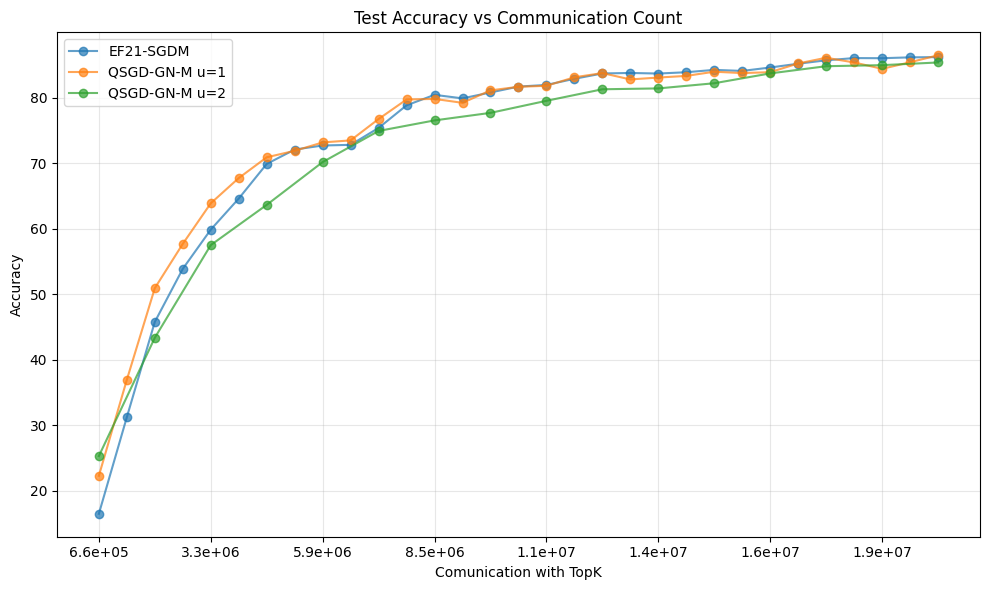

In [157]:
import matplotlib.pyplot as plt
import numpy as np
figsize=(10, 6)
title='Test Accuracy vs Communication Count'
acc_results

plt.figure(figsize=figsize)

x = np.arange(0,(len(acc_results["EF21-SGDM"])+1)*32815*20,32815*20)
    
plt.plot(x[1:], acc_results["EF21-SGDM"], '-o', label="EF21-SGDM", alpha=0.7)
plt.plot(x[1:], acc_results["QSGD-GN-M u=1"], '-o', label="QSGD-GN-M u=1", alpha=0.7)
plt.plot(x[1::2], acc_results["QSGD-GN-M u=2"][::2], '-o', label="QSGD-GN-M u=2", alpha=0.7)
plt.title(title)
plt.ticklabel_format(style='scientific', axis='x', scilimits=(0,0), useOffset=False)
plt.gca().xaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))
plt.gca().xaxis.get_major_formatter().set_powerlimits((0, 0))
plt.gca().xaxis.get_major_formatter().set_scientific(True)
plt.gca().xaxis.get_major_formatter().set_useMathText(True)

# 设置小数位数
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1e}'))
plt.xlabel('Comunication with TopK')
plt.ylabel('Accuracy')
plt.xticks(x[1:len(x):4])
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()